In [1]:
import scipy
from scipy.interpolate import CubicSpline as CubicSpline
from scipy.interpolate import interp1d as interp1d
import pandas as pd
import numpy as np
#интерполяция
from scipy.interpolate import interp1d
#Рисование графиков
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
%matplotlib inline

In [2]:
#Старый метод
# data= pd.read_excel('nasdaq-composite.xlsx')
# data.columns=['date','value']
# data

In [3]:
data= pd.read_csv('Nasdaq_compose_Yahoo.csv')

#Выбираем нужные столбцы
data=data[['Date', 'Adj Close']]
data.columns=['date', 'value']

In [4]:
def slice_data(df, slice_period):
    #2 сортировки, чтобы последняя дата оставалась
    return df.copy().sort_values(by='date', ascending=False)[::slice_period].sort_values(by='date').reset_index(drop=True)

In [5]:
slice_period=30
# Прореживаем данные и сортируем по дате
df=slice_data(data,slice_period)

# Нормализуем данные по нужному периоду
# df['value']=df['value'].apply(lambda x: x/df.iloc[period_num].value)
# df.iloc[period_num]['date']

# Преобразуем в формат времени
df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d')
df

,date,value
0,1990-01-30,410.700012
1,1990-03-14,436.200012
2,1990-04-26,421.100006
3,1990-06-08,460.899994
4,1990-07-23,444.600006
...,...,...
263,2021-05-25,13657.169922
264,2021-07-08,14559.780273
265,2021-08-19,14541.790039
266,2021-10-01,14566.700195


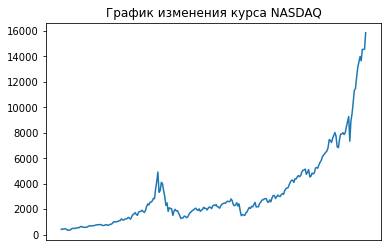

In [6]:
plt.plot(df['date'], df['value'])
plt.title('График изменения курса NASDAQ');
plt.xticks([])
plt.show()

In [72]:
# # Вводим вместо y разницу между ними
# x=x[1:]
# y=np.diff(y)
# step=.05
# xx = np.arange(1, data_length+step, step=step)
# # xx = np.linspace(x.min(), x.max(), num=round(data_length/step), endpoint=True)
# spline = CubicSpline(x, y, bc_type='clamped')
# yy=spline(xx)
# ww=np.diff(yy)
# plt.plot(xx[1:],ww**2)

In [8]:
def get_arange(length, step):
    return np.arange(1, length+step, step=step)

def deriv_spline(spline, n):
    # Находим производные сплайна порядка 0-3
    pp=[]
    for i in range(n):
        pp.append(spline.derivative(i))
    return pp

def calc_spline_values(xx, pp):
    # Вычисляем значения для производных сплайна
    ppf=[]
    for i in range(len(pp)):
        ppf.append(pp[i](xx))
    return ppf

def interpolate(ppf, step):
    # Задаем интервалы для интерполяции
    t=np.arange(1, ppf[0].shape[0]+1)
    pp1f_y=get_arange(ppf[0].shape[0], step=step)
    # Производим интерполяцию
    interp1=lambda x: interp1d(t, x, kind='cubic', fill_value="extrapolate")(pp1f_y) # нужен ли параметр fill_value
    deriv=[]
    for i in range(len(ppf)):
        deriv.append(interp1(ppf[i]))
    return deriv

def get_phase_portrait(x, y, step_spline=0.05,step_deriv=.01, deriv_num=4):
    #Высчитываем данные портрета и xx
    xx = get_arange(x.shape[0], step=step_spline)
    spline = CubicSpline(x, y, bc_type='clamped')
    yy=spline(xx)
    pp=deriv_spline(spline, deriv_num)
    ppf=calc_spline_values(xx, pp)
    
    deriv=interpolate(ppf, step_deriv)
    return xx, deriv

In [9]:
def get_ticks(arr, num=5):
    #Поиск нужного кол-во делений на шкалах, возвращает массив с данными
    assert num>2
    
    mask=np.linspace(0, arr.shape[0]-1, num=num).round().astype(int)
    if type(arr)==pd.core.frame.DataFrame or type(arr)==pd.core.series.Series:
        return [arr.iloc[i] for i in mask]
    else:
        return [arr[i] for i in mask]

In [114]:
x=df.index.to_series()+1
y=df['value']
y=y/1000
xx, deriv=get_phase_portrait(x,y, step_spline=.05, step_deriv=.01, deriv_num=4)
func=deriv[0]

In [116]:
step=.0005
# tt = np.linspace(0, x.max(), num=np.floor(data_length/step), endpoint=True)
tt=get_arange(x.shape[0], step=step)

True

In [103]:
# data_step=round(tt.shape[0]/x.shape[0])

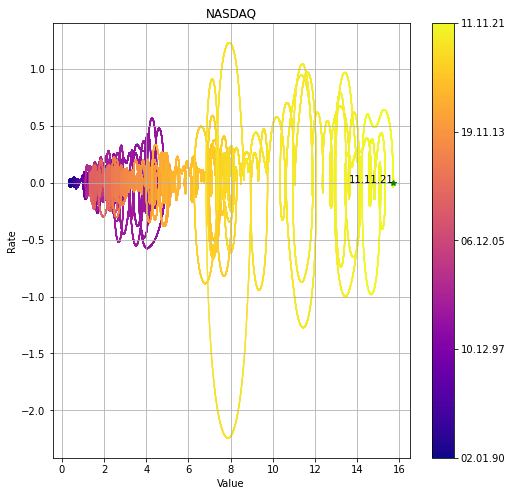

In [81]:
cmap = plt.cm.plasma
norm = plt.Normalize(x.min(), x.max())

c_bar=plt.cm.plasma(np.linspace(0, 1, tt.shape[0]))

fig, ax = plt.subplots()
ax.scatter(func, deriv[1], c=c_bar, s=0.05)
cax=ax.plot(func[-1], deriv[1][-1], '*g', markersize=6)
ax.annotate(df['date'].iloc[-1].strftime('%d.%m.%y'),  xy=(func[-1], deriv[1][-1]), color='black', ha="right")
ax.set_ylabel('Rate')
ax.set_xlabel('Value')

plt.title('NASDAQ')

fig.set_figheight(8)
fig.set_figwidth(8)

# fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
#              cax=cax, orientation='vertical')
# fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=years, orientation='vertical')
ticks_num=5
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=get_ticks(xx, ticks_num), orientation='vertical')
cbar.ax.set_yticklabels(map(lambda x: x.strftime('%d.%m.%y'), get_ticks(df['date'], ticks_num)))

plt.grid()
# plt.show()
plt.savefig('Nasdaq_test_1.png')

In [10]:
def plot_phase_portrait(x, xx, dates, deriv, tt, name, ticks_num=5, save_fig_name='', y_limits=(), x_limits=()):
    cmap = plt.cm.plasma
    norm = plt.Normalize(x.min(), x.max())

    c_bar=plt.cm.plasma(np.linspace(0, 1, tt.shape[0]))

    fig, ax = plt.subplots()
    ax.scatter(deriv[0], deriv[1], c=c_bar, s=0.05)
    cax=ax.plot(deriv[0][-1], deriv[1][-1], '*g', markersize=6)
    ax.annotate(dates.iloc[-1].strftime('%d.%m.%y'),  xy=(deriv[0][-1], deriv[1][-1]), color='black', ha="right")
    ax.set_ylabel('Rate')
    ax.set_xlabel('Value')

    plt.title(name)

    fig.set_figheight(8)
    fig.set_figwidth(8)
    
    
    cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ticks=get_ticks(xx, ticks_num), orientation='vertical')
    cbar.ax.set_yticklabels(map(lambda x: x.strftime('%d.%m.%y'), get_ticks(df['date'], ticks_num)))
    if len(y_limits)==2:
        plt.ylim(y_limits)
    if len(x_limits)==2:
        plt.xlim(x_limits)
    plt.grid()
#     plt.show()
    if save_fig_name:
        plt.savefig(f"{save_fig_name}.png", dpi=200)

In [11]:
def get_filename(name, min_date, max_date, freq):
    return f"{name}_{min_date}_to_{max_date}_f_{freq}"

In [118]:
slice_period=1

filename=get_filename(name, df['date'].min().strftime('%d_%m_%y'), df['date'].max().strftime('%d_%m_%y'), slice_period)

df=slice_data(data,slice_period)

df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d')

x=df.index.to_series()+1
y=df['value']
y=y/1000
xx, deriv=get_phase_portrait(x,y, step_spline=.05, step_deriv=.01, deriv_num=4)
func=deriv[0]

step=.0005
tt=get_arange(x.shape[0], step=step)
# plt.xlim([25, 50])

In [12]:
def calc_phase_portrait(df, slice_period):

    df=slice_data(data,slice_period)

    df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d')

    x=df.index.to_series()+1
    y=df['value']
    y=y/1000
    xx, deriv=get_phase_portrait(x,y, step_spline=.05, step_deriv=.01, deriv_num=4)
    func=deriv[0]

    step=.0005
    tt=get_arange(x.shape[0], step=step)
    return (x, y, xx, deriv, tt, slice_period)

In [13]:
def generate_phase_portrait(df, slices):
    data=[]
    for slice_period in slices:
        data.append(calc_phase_portrait(df, slice_period))
    return data

In [17]:
name='NASDAQ Composite'
generated_data=generate_phase_portrait(df, [1,7,30])

In [21]:
# from itertools import chain
# y_lims=list(chain(*[(min(slice_data[3][1]), max(slice_data[3][1])) for slice_data in generated_data]))
# y_lims=tuple(map(np.ceil,(min(y_lims), max(y_lims))))
y_lim=(-2.7, 2.5)
x_lim=(0, 17)

In [22]:
def generate_png():
    for data in generated_data:
        x, y, xx, deriv, tt, slice_period = data

        filename=get_filename(name, df['date'].min().strftime('%d_%m_%y'), df['date'].max().strftime('%d_%m_%y'), slice_period)

        plot_phase_portrait(x, xx, df['date'], deriv, tt, f"{name} t={slice_period}", ticks_num=5, save_fig_name='./Nasdaq_img/'+filename, y_limits=y_lim, x_limits=x_lim)

Wall time: 4min 32s


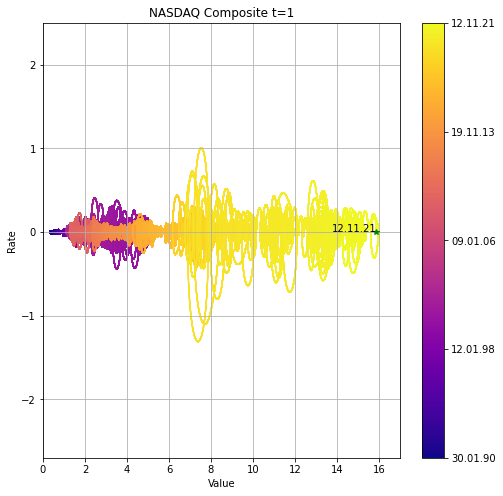

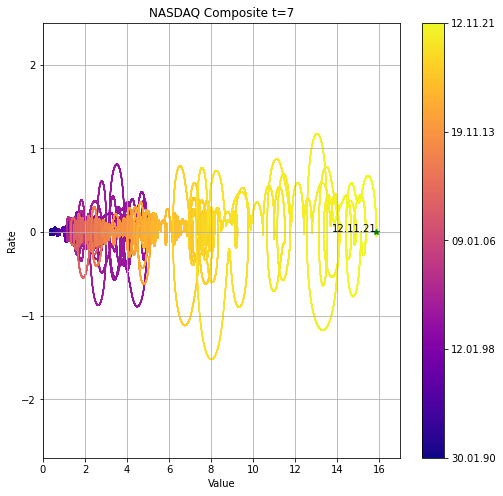

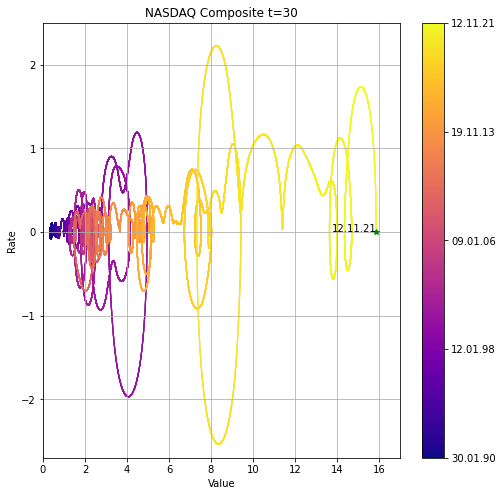

In [23]:
%time generate_png()

In [32]:
deriv_1= generated_data[0][3]
deriv_7 = generated_data[1][3]
deriv_30 = generated_data[2][3]

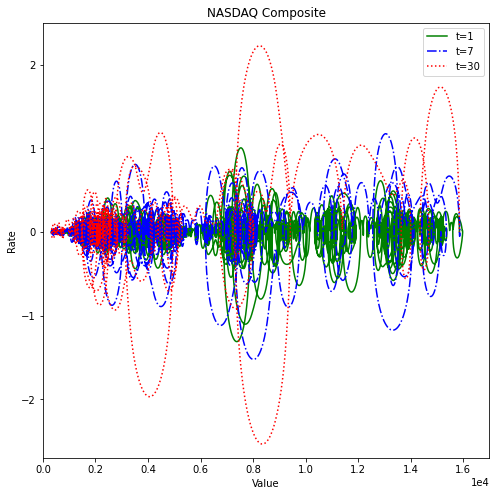

In [57]:
fig, ax = plt.subplots()
ax.plot(deriv_1[0]*1000, deriv_1[1], '-g', deriv_7[0]*1000, deriv_7[1], '-.b', deriv_30[0]*1000, deriv_30[1], ':r')
# ax.plot(deriv_30[0], deriv_30[1], ':g', deriv_7[0], deriv_7[1], '-.b', deriv_1[0], deriv_1[1], '-r')
plt.ylim(y_lim)
plt.xlim(tuple(map(lambda x: x*1000, x_lim)))
plt.title(name)
ax.set_ylabel('Rate')
ax.set_xlabel('Value')
plt.legend(['t=1', 't=7', 't=30' ], loc='best')

fig.set_figheight(8)
fig.set_figwidth(8)

filename=get_filename(name, df['date'].min().strftime('%d_%m_%y'), df['date'].max().strftime('%d_%m_%y'), slice_period)

ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')

plt.savefig(f"./Nasdaq_img/{filename}_comparison.png", dpi=200)
# plt.show()